# NLP Lab2 - Lemmatization and full text search (FTS)

**Author: Bartłomiej Jamiołkowski**

The task is concentrated on using full text search engine (ElasticSearch) to perform basic search operations in a text corpus.

In [2]:
from elasticsearch import Elasticsearch, helpers
from datasets import load_dataset
from roman import toRoman
from babel.dates import get_month_names
from translate import Translator
from collections import OrderedDict
import pandas as pd
import calendar
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
es = Elasticsearch(
    'https://host.docker.internal:9200',
    verify_certs = False,
    basic_auth = ('elastic', 'B96cbDsJJzL6AV9nArVs'))

print(es.info())

{'name': 'a02ac4a4f9f8', 'cluster_name': 'docker-cluster', 'cluster_uuid': '12NhjPSCTn6AuGdMKGOyDg', 'version': {'number': '8.15.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'f97532e680b555c3a05e73a74c28afb666923018', 'build_date': '2024-10-09T22:08:00.328917561Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'}


## Task 1

Install ElasticSearch (ES).

## Task 2

Install an ES plugin for Polish https://github.com/allegro/elasticsearch-analysis-morfologik

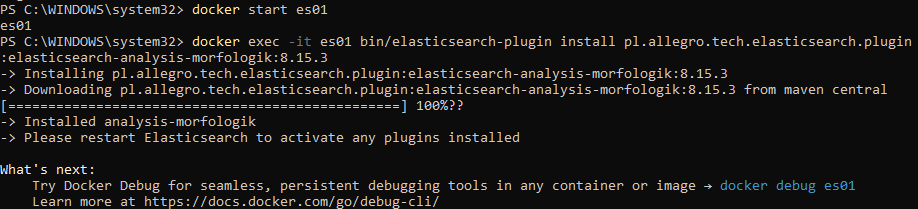

## Tasks 3 - 4

Task 3: Define an ES analyzer for Polish texts containing: <br>
i, standard tokenizer <br>
ii, synonym filter with alternative forms for months, e.g. kwiecień, kwi, IV. <br>
iii, lowercase filter <br>
iv, Morfologik-based lemmatizer <br>
v, lowercase filter (looks strange, but Morfologi produces capitalized base forms for proper names, so we have to lowercase them once more).

Task 4: Define another analyzer for Polish, without the synonym filter.

As part of this task, I decided to create a list of alternative forms for Polish months, which is later used in index configuration. Instead of writing out all the forms manually, I aimed to automate the process. First, I created a list of Polish month names based on calendar data. Then, I found a way to generate abbreviated forms of the Polish months. Finally, I obtained Roman numerals for the interval from I to XII. I combined the elements from all lists to create the mentioned list of alternative forms for Polish months.

In [4]:
translator = Translator(to_lang = 'pl')
months_pl = list(map(lambda m: translator.translate(m).lower(), list(calendar.month_name)[1:]))

months_abbreviated_pl = list(get_month_names(width = 'abbreviated', locale = 'pl_PL').values())

months_roman = list(map(lambda m: toRoman(m), list(range(1, 13))))

polish_synonyms_of_months = [', '.join(OrderedDict.fromkeys([name, abbr, num])) for name, abbr, num in zip(months_pl, months_abbreviated_pl, 
                            months_roman)]
polish_synonyms_of_months

['styczeń, sty, I',
 'luty, lut, II',
 'marzec, mar, III',
 'kwiecień, kwi, IV',
 'maj, V',
 'czerwiec, cze, VI',
 'lipiec, lip, VII',
 'sierpień, sie, VIII',
 'wrzesień, wrz, IX',
 'październik, paź, X',
 'listopad, lis, XI',
 'grudzień, gru, XII']

Below, I created an index configuration with analyzers for all tasks in this laboratory.

In [5]:
index_configuration = {
    'settings': {
        'analysis': {
            'analyzer': {
                'polish_analyzer_synonyms_lemmatization': {
                    'type': 'custom',
                    'tokenizer': 'standard',
                    'filter': [
                        'polish_synonyms_of_months', 
                        'lowercase', 
                        'morfologik_stem', 
                        'lowercase'
                    ]
                },
                'polish_analyzer_lemmatization': {
                    'type': 'custom',
                    'tokenizer': 'standard',
                    'filter': [
                        'lowercase', 
                        'morfologik_stem', 
                        'lowercase'
                    ]
                },
                'polish_analyzer_synonyms': {
                    'type': 'custom',
                    'tokenizer': 'standard',
                    'filter': [
                        'polish_synonyms_of_months', 
                        'lowercase'
                    ]
                },
                'polish_analyzer': {
                    'type': 'custom',
                    'tokenizer': 'standard',
                    'filter': [
                        'lowercase'
                    ]
                },    
            },
            'filter': {
                'polish_synonyms_of_months':{
                    'type': 'synonym',
                    'synonyms': polish_synonyms_of_months
                }
            }
        }
    },
    'mappings': {
        'properties': {
            'text_with_synonyms_lemmatization': {
                'type': 'text',
                'analyzer': 'polish_analyzer_synonyms_lemmatization'
            },
            'text_with_lemmatization': {
                'type': 'text',
                'analyzer': 'polish_analyzer_lemmatization'
            },
            'text_with_synonyms': {
                'type': 'text',
                'analyzer': 'polish_analyzer_synonyms'
            },
            'text': {
                'type': 'text',
                'analyzer': 'polish_analyzer'
            }
        }
    }
}

## Task 5

Define an ES index for storing the contents of the corpus FiQA-PL using both analyzers. Use different names for the fields analyzed with a different pipeline.

In [7]:
#es.indices.delete(index = 'fiqa_pl_index')
es.indices.create(index = 'fiqa_pl_index', body = index_configuration)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'fiqa_pl_index'})

## Task 6

Load the data to the ES index.

In [9]:
fiqa_pl = load_dataset('clarin-knext/fiqa-pl', 'corpus')
fiqa_pl_df = fiqa_pl['corpus'].to_pandas()
fiqa_pl_text_list = fiqa_pl_df.to_dict('records')

In [10]:
fiqa_pl_text_list[:4]

[{'_id': '3',
  'title': '',
  'text': 'Nie mówię, że nie podoba mi się też pomysł szkolenia w miejscu pracy, ale nie możesz oczekiwać, że firma to zrobi. Szkolenie pracowników to nie ich praca – oni tworzą oprogramowanie. Być może systemy edukacyjne w Stanach Zjednoczonych (lub ich studenci) powinny trochę martwić się o zdobycie umiejętności rynkowych w zamian za ich ogromne inwestycje w edukację, zamiast wychodzić z tysiącami zadłużonych studentów i narzekać, że nie są do niczego wykwalifikowani.'},
 {'_id': '31',
  'title': '',
  'text': 'Tak więc nic nie zapobiega fałszywym ocenom poza dodatkową kontrolą ze strony rynku/inwestorów, ale istnieją pewne nowsze kontrole, które uniemożliwiają instytucjom korzystanie z nich. W ramach DFA banki nie mogą już polegać wyłącznie na ratingach kredytowych jako należytej staranności przy zakupie instrumentu finansowego, więc to jest plus. Intencją jest to, że jeśli instytucje finansowe wykonują swoją własną pracę, to *być może* dojdą do wniosku,

In this part of the lab, I am using helpers.bulk(). This function allows me to send large amounts of data to Elasticsearch in a single request, which makes the entire data-loading process much faster. For this task, I previously created a list of dictionaries, which I am now passing as an iterable data structure to a custom function that creates indexing actions for bulk insertion in Elasticsearch.

In [11]:
def index_textual_data(iterable_data):
    iterable_actions = [
    {'_op_type': 'index',
     '_index': 'fiqa_pl_index',
     '_source': {
        'text_with_synonyms_lemmatization': element['text'],
        'text_with_lemmatization': element['text'],
        'text_with_synonyms': element['text'],
        'text': element['text'],
        'title': element['title'],
        'id': element['_id']
        }
    }
    for element in iterable_data]

    return iterable_actions

helpers.bulk(es, index_textual_data(fiqa_pl_text_list))

(57638, [])

## Task 7

Determine the number of documents and the number of matches containing the word kwiecień (in any form) including and excluding the synonyms.

In [12]:
def build_query(queried_field, analyzer_name):
    query = {
        'query': {
            'match': {
                queried_field: {
                    'query': 'kwiecień',
                    'analyzer': analyzer_name
                }
            }
        }
    }
    return query

docs_num_with_synonyms = es.count(index = 'fiqa_pl_index', body = build_query('text_with_synonyms_lemmatization', 
                                                                            'polish_analyzer_synonyms_lemmatization'))['count']

print(f'Number of documents including "kwiecień" with synonyms: {docs_num_with_synonyms}')

docs_num_without_synonyms = es.count(index = 'fiqa_pl_index', body = build_query('text_with_lemmatization', 
                                                                               'polish_analyzer_lemmatization'))['count']

print(f'Number of documents including "kwiecień" without synonyms: {docs_num_without_synonyms}')

Number of documents including "kwiecień" with synonyms: 306
Number of documents including "kwiecień" without synonyms: 257


## Task 8

Download the QA pairs for the FiQA-PL dataset.

In [13]:
fiqa_pl_queries_df = load_dataset('clarin-knext/fiqa-pl', 'queries')['queries'].to_pandas()
fiqa_pl_test_df = load_dataset('clarin-knext/fiqa-pl-qrels', 'default')['test'].to_pandas()

In [14]:
fiqa_pl_queries_df.head()

,_id,title,text
0,0,,Co jest uważane za wydatek służbowy w podróży ...
1,4,,Wydatki służbowe - ubezpieczenie samochodu pod...
2,5,,Rozpoczęcie nowego biznesu online
3,6,,„Dzień roboczy” i „termin płatności” rachunków
4,7,,Nowy właściciel firmy – Jak działają podatki d...


In [15]:
fiqa_pl_test_df.head()

,query-id,corpus-id,score
0,8,566392,1
1,8,65404,1
2,15,325273,1
3,18,88124,1
4,26,285255,1


## Task 9

Compute NDCG@5 for the QA dataset (the test subset) for the following setups:
- synonyms enabled and disabled,
- lemmatization in the query enabled and disabled.

For this task I am using index configuration placed in task 3. Inside it I placed four analyzers: with synonyms and lemmatization, with lemmatization, with synonyms, without synonyms and lemmatization.

In [20]:
def search_answers_ids(es, index_name, query, analyzer, text):
    body_query = {
        'query': {
            'match': {
                text: {
                    'query': query,
                    'analyzer': analyzer
                }
            }
        },
        '_source': ['id']
    }
    
    response = es.search(index = index_name, body = body_query)['hits']['hits'][:5]
    return [hit['_source']['id'] for hit in response]

def compute_ncdgk(answers_ids, revelant_ids, k):
    dcg = sum(1 / math.log(i + 2, 2) for i in range(k) if int(answers_ids[i]) in revelant_ids)
    idcg = sum(1 / math.log(i + 2, 2) for i in range(min(len(revelant_ids), k)))
    
    return dcg / idcg
    
def compute_analyzer_mean_ncdg5(analyzer, text):
    ncdg5_scores = []
    
    for query_id in fiqa_pl_test_df['query-id'].unique():
        query = fiqa_pl_queries_df[str(query_id) == fiqa_pl_queries_df['_id']].iloc[0]['text']
        answers_ids = search_answers_ids(es, 'fiqa_pl_index', query, analyzer, text)
        relevant_ids = fiqa_pl_test_df[query_id == fiqa_pl_test_df['query-id']]['corpus-id'].tolist()
        ncdg5_score = compute_ncdgk(answers_ids, relevant_ids, k = 5)
        ncdg5_scores.append(ncdg5_score)

    return np.mean(ncdg5_scores)

In [21]:
results_dict = {
    'Polish analyzer with synonyms and lemmatization': ['polish_analyzer_synonyms_lemmatization', 'text_with_synonyms_lemmatization'],
    'Polish analyzer without synonyms and with lemmatization': ['polish_analyzer_lemmatization', 'text_with_lemmatization'],
    'Polish analyzer with synonyms and without lemmatization': ['polish_analyzer_synonyms', 'text_with_synonyms'],
    'Polish analyzer without synonyms and without lemmatization': ['polish_analyzer', 'text']
}

print('Mean NCDG@5 for analyzers:')
for setup, params in results_dict.items():
    print(f'{setup}: {compute_analyzer_mean_ncdg5(params[0], params[1])}')

Mean NCDG@5 for analyzers:
Polish analyzer with synonyms and lemmatization: 0.1851291130797741
Polish analyzer without synonyms and with lemmatization: 0.1851291130797741
Polish analyzer with synonyms and without lemmatization: 0.13854570378524392
Polish analyzer without synonyms and without lemmatization: 0.13854570378524392


Obtained results indicate that mean NCDG@5 is higher for analyzers with lemmantization.

## Task 10 (Optional)

Find three questions from the test subset with the following features: <br>
- the relevant document is returned by ES at position 1,
- the relevant document is returned by ES at position 4 or 5.
- the relevant document is returned by ES is not found.

In [25]:
def search_features(query, query_id, results_dict, answers_ids, relevant_ids):
    if len(relevant_ids) != 1:
        return results_dict

    relevant_ids = list(filter(lambda idx: int(answers_ids[idx]) in relevant_ids, range(5)))
    
    if not relevant_ids:
        results_dict['not_found'].append([query, query_id])
        
        return results_dict

    if relevant_ids[0] == 0:
        results_dict['position_1'].append([query, query_id])
    elif relevant_ids[0] in [3, 4]:
        results_dict['position_4_5'].append([query, query_id])

    return results_dict

def find_questions(analyzer, text):
    results_dict = {'position_1': [], 'position_4_5': [], 'not_found': []}

    for query_id in fiqa_pl_test_df['query-id'].unique():
        query = fiqa_pl_queries_df[str(query_id) == fiqa_pl_queries_df['_id']].iloc[0]['text']
        answers_ids = search_answers(es, 'fiqa_pl_index', query, analyzer, text)
        relevant_ids = fiqa_pl_test_df[query_id == fiqa_pl_test_df['query-id']]['corpus-id'].to_list()
        results_dict = search_features(query, query_id, results_dict, answers_ids, relevant_ids)

    return results_dict

found_questions = find_questions('polish_analyzer_synonyms_lemmatization', 'text_with_synonyms_lemmatization')

print('Example three questions for which relevant documents were returned with following features:')
print(f'position 1: {found_questions["position_1"][0][0]}')
print(f'position 4 or 5: {found_questions["position_4_5"][2][0]}')
print(f'not found: {found_questions["not_found"][1][0]}')

Example three questions for which relevant documents were returned with following features:
position 1: Jak rozliczyć zarobione i wydane pieniądze przed założeniem firmowych kont bankowych?
position 4 or 5: Konsekwencje podatkowe zmiany wartości walut obcych
not found: 401k Przelew po zamknięciu firmy


## Task 11 (Optional)

Analyze the possible reasons for these outcomes.

For the first question, where Elasticsearch returned a relevant answer at position 1, it is noticeable that there are many well-defined keywords. As a result, more relevant answers can be obtained.

For the second question, where Elasticsearch returned a relevant answer at positions 4 or 5, there are fewer keywords. It is possible that these keywords are also common in other answers.

For the third question, where Elasticsearch did not return a relevant answer, it is noticeable that this 'question' is not actually a question. It does not contain many keywords. It is very likely that this dataset contains many entries about companies and financial transactions, which results in difficulties in finding useful answers for this particular 'question'.

## Question 1

What are the strengths and weaknesses of regular expressions versus full text search regarding processing of text?

Regular expressions have an edge over full text search in terms of strict pattern matching and setup complexity. Of course, some regular patterns can become complex for advanced tasks, but even then, they do not require as much code or setup as full-text search engines, which need to be configured and maintained.

On the other hand, regular expressions are outperformed by full text search in aspects such as relevance, as regex does not prioritize results by relevance. Moreover, they have limited scalability. In case of dealing with large datasets, regular expressions can be slower than full text search.

## Question 2

Can an LLM be applied in the context of searching for documents? Justify your answer, excluding the obvious observation that an LLM can be used to formulate the answer.

Broadly speaking, an LLM can be applied in the context of searching for documents. First, LLMs can match a query to relevant documents based on contextual similarity. Furthermore, they do not require lemmatization to recognize synonyms or related concepts. Finally, LLMs can parse and disambiguate components of a query to deliver more precise results.